In [2]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import rotate
from skimage import data, color

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
datadir='/content/drive/MyDrive/cartes_epaisseur' 

list_LS = []
list_LP = []
list_RS = []
list_RP = []
ids_S = [49,50,55,57,58,59,60,61,62,63,64,65,67,68,69,70,71,73,74,75]
ids_P = [1,2,3,4,6,10,12,18,19,20,25]

for i in ids_S:
    image_name = '/carte_epaisseur_gauche/Segmentation_Tibia1_%02d_mesh.png'%(i)
    list_LS.append(datadir + image_name)
    image_name = '/carte_epaisseur_droite/Segmentation_Tibia2_%02d_mesh.png'%(i)
    list_RS.append(datadir + image_name)

for i in ids_P:
    image_name = '/carte_epaisseur_gauche_patho/Segmentation_Tibia1_%02d_mesh.png'%(i)
    list_LP.append(datadir + image_name)
    image_name = '/carte_epaisseur_droite_patho/Segmentation_Tibia2_%02d_mesh.png'%(i)
    list_RP.append(datadir + image_name)

In [14]:
from scipy.optimize import minimize
from scipy.ndimage.interpolation import affine_transform

nbins = 32
bins = (nbins, nbins)

def mi(reference,moving):
  #fonction donnant l'information mutuelle entre les 2 images
  jh = np.histogram2d(reference.flatten(), moving.flatten(), bins=bins)[0] 
  jh = jh + np.finfo(float).eps # évite de gérer les zeros dans jh
  mi=0
  P_x=np.histogram(reference.flatten(),bins=bins[0])[0]
  P_y=np.histogram(moving.flatten(),bins=bins[0])[0]
  for i in range(len(jh)):
    for j in range(len(jh)):
      mi += (jh[i][j]/np.sum(jh))*np.log((jh[i][j]/np.sum(jh))/((P_x[i]/np.sum(P_x))*(P_y[j]/np.sum(P_y))))
  return mi

def mat_trans(x,img_ref):
  #construit la matrice de transformation affine
  sizex,sizey=np.shape(img_ref)
  rot1 = [[1,0,sizex/2],[0,1,sizey/2],[0,0,1]]
  rot2 = [[np.cos(x[0]*np.pi/180),-np.sin(x[0]*np.pi/180),0],[np.sin(x[0]*np.pi/180),np.cos(x[0]*np.pi/180),0],[0,0,1]]
  rot3 = [[1,0,-sizex/2],[0,1,-sizey/2],[0,0,1]]
  tran = [[1,0,x[1]],[0,1,x[2]],[0,0,1]]
  return np.dot(np.dot(np.dot(tran,rot1),rot2),rot3)


def f_mi_af(x,img_ref, img_recal):
  #nouvelle fonction de coût prenant en compte la transformation affine
  return -mi(img_ref, affine_transform(img_recal,mat_trans(x,img_ref)))



Optimization terminated successfully.
         Current function value: -0.509657
         Iterations: 5
         Function evaluations: 350
[11.85071707  1.3989578  -3.31257242]


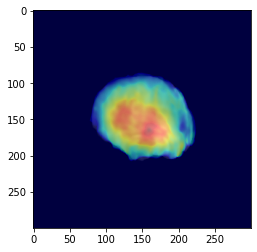

In [18]:
import cv2

x = [20,0,0]
img_ref=cv2.imread(list_LS[0], cv2.IMREAD_GRAYSCALE)
img_recal=cv2.imread(list_LS[4], cv2.IMREAD_GRAYSCALE)

res = minimize(f_mi_af, x, args=(img_ref, img_recal), method= "Powell", options={'maxiter': 10, 'disp':True})
print(res.x)

plt.imshow(img_ref, cmap='gray')
plt.imshow(affine_transform(img_recal,mat_trans(res.x,img_ref)), alpha = 0.5, cmap='jet')
plt.show()